# Evaluation of SMS Spam Message Classification Model

### Victor Chua Min Chun 0129219
#### 0129219@kdu-online.com

## Libraries & Functions

In [7]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import wordcloud

import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import os

In [8]:
# Classification report & Accuracy
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# **Part 1: EDA**

In [9]:
data = pd.read_csv(r'C:\Users\vcmc4\Desktop\Classes\Data Sci Jupyter\Assignment\spam.csv', encoding = 'latin-1')
data = data.dropna(axis='columns')
data = data.rename(columns= {"v1":"Label"})
data = data.rename(columns= {"v2":"Text"})
data.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.groupby("Label").describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

### Distribution of the target variable

In [11]:
data.Label.value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

<AxesSubplot:>

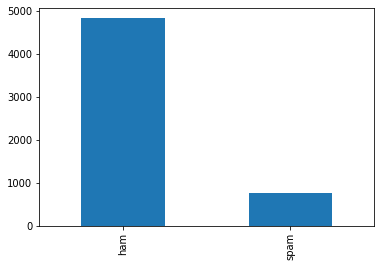

In [12]:
data.Label.value_counts().plot.bar()

### Add numerical label for spam   
Target must be numerical for ML classification models

In [13]:
data['spam'] = data['Label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(15)

,Label,Text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


### 1.2 length of message

### Add feature: length of message

In [14]:
data['length'] = data['Text'].apply(len)

In [15]:
data.head(10)

,Label,Text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


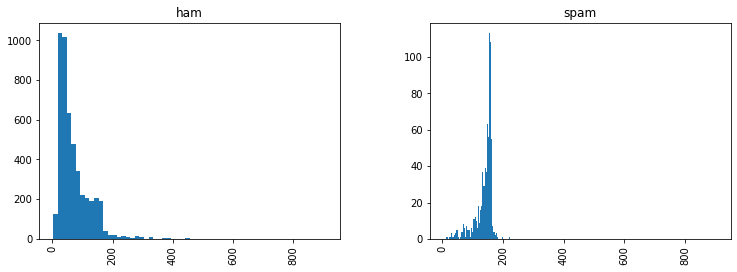

In [16]:
data.hist(column='length',by='Label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

Looks like spam messages are generally longer than ham messages:  
Bulk of ham has length below 100, for spam it is above 100.  
We will check if this feature is useful for the classification task in Part 3.  

In [17]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()

# **Part 2: Preprocessing**

## Remove Punctuation and Stopwords

In [19]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Stopwords  
from sklearn documentation:  https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words  
Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text,   
and which may be removed to avoid them being construed as signal for prediction.  
Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.  

Due to the known issues in the ’english’ stop word list of sklearn, we use the stopwords from NLTK:

**NLTK**

In [20]:
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

In [21]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [22]:
data['Text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: Text, dtype: object

### Top 30 words in ham and spam messages

### Collections: Counter

In [23]:
from collections import Counter

In [24]:
data_ham.loc[:, 'Text'] = data_ham['Text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['Text'].tolist()
data_spam.loc[:, 'Text'] = data_spam['Text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['Text'].tolist()

In [25]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

In [26]:
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [27]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

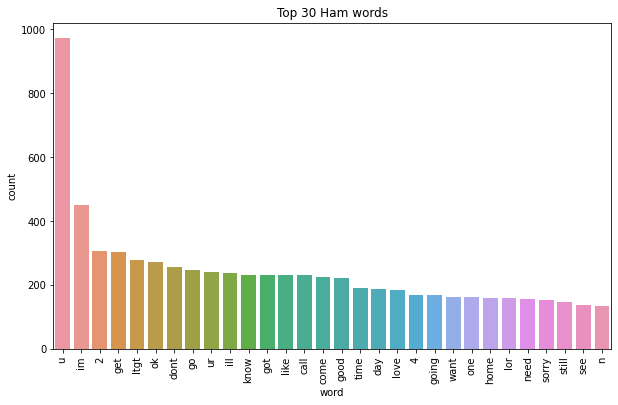

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

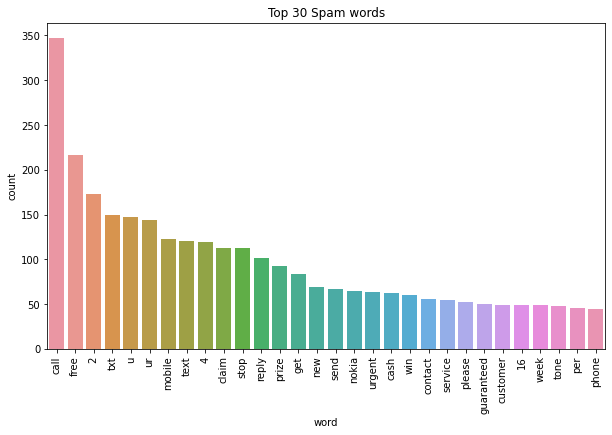

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

### NLTK: FreqDist

In [30]:
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [31]:
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

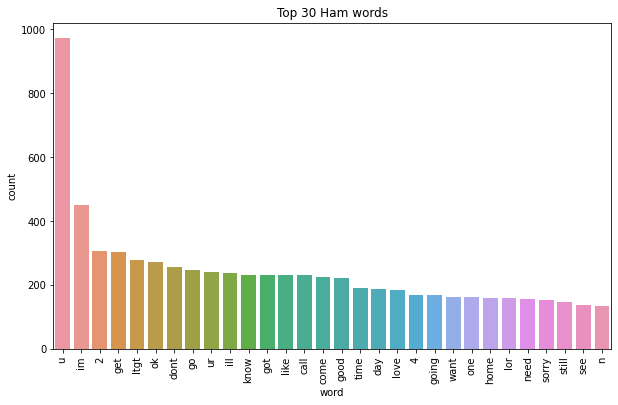

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

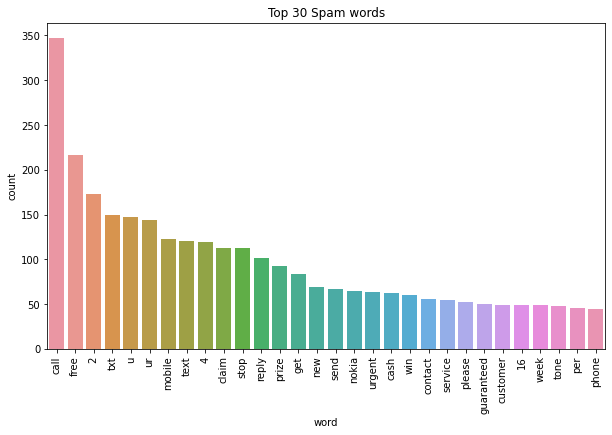

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## Bag of words with CountVectorizer

### The Bag of Words representation

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['Text'])

In [35]:
print(len(bow_transformer.vocabulary_))

9431


In all sms messages bow_transformer counted 9431 different words.

### Examples for spam and ham messages

In [36]:
sample_spam = data['Text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [37]:
rows, cols = bow_sample_spam.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

09061701461
12
call
claim
code
customer
hours
kl341
network
prize
receivea
reward
selected
valid
valued
winner
å£900


In [38]:
print(np.shape(bow_sample_spam))

(1, 9431)


In [39]:
sample_ham = data['Text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah I don't think he goes to usf, he lives around here though
  (0, 1279)	1
  (0, 2882)	1
  (0, 3762)	1
  (0, 5004)	1
  (0, 5631)	1
  (0, 8224)	1
  (0, 8243)	1
  (0, 8664)	1


In [40]:
rows, cols = bow_sample_ham.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

around
dont
goes
lives
nah
think
though
usf


### Applying bow_transformer on all messages

In [41]:
bow_data = bow_transformer.transform(data['Text'])

In [42]:
bow_data.shape

(5572, 9431)

In [43]:
bow_data.nnz

49772

In [44]:
bow_data

<5572x9431 sparse matrix of type '<class 'numpy.int64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [45]:
bow_data.shape[0]

5572

In [46]:
bow_data.shape[1]

9431

In [47]:
bow_data.nnz

49772

number of none zero entries divided by matrix size  

In [48]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09471444959776236


Around 10% of the matrix are non zeros (=ones)

## Term frequency inverse document frequency - TFIDF

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [50]:
tfidf_sample_ham = tfidf_transformer.transform(bow_sample_ham)
print(tfidf_sample_ham)

  (0, 8664)	0.4000611457714059
  (0, 8243)	0.35462891367407595
  (0, 8224)	0.2665748147939407
  (0, 5631)	0.40493594386802356
  (0, 5004)	0.44910913790937335
  (0, 3762)	0.35674330934716636
  (0, 2882)	0.23016324066220836
  (0, 1279)	0.31179198007951625


In [51]:
tfidf_sample_spam = tfidf_transformer.transform(bow_sample_spam)
print(tfidf_sample_spam)

  (0, 9418)	0.2604683359422661
  (0, 9028)	0.23445094204464131
  (0, 8698)	0.24115248419490207
  (0, 8694)	0.22254833340975305
  (0, 7209)	0.2148462495005997
  (0, 6946)	0.2564029044370425
  (0, 6775)	0.2943229069695555
  (0, 6538)	0.178899142428953
  (0, 5707)	0.2148462495005997
  (0, 4759)	0.2943229069695555
  (0, 4194)	0.22555164191980467
  (0, 2531)	0.1915015107445745
  (0, 2245)	0.21371446699888028
  (0, 2184)	0.3406301232141347
  (0, 1906)	0.1153380143353214
  (0, 323)	0.2387711073538672
  (0, 218)	0.2943229069695555


In [52]:
data_tfidf = tfidf_transformer.transform(bow_data)

In [53]:
data_tfidf

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [54]:
np.shape(data_tfidf)

(5572, 9431)

## train test split

for TFIDF matrix only

In [55]:
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, Label_train, Label_test = \
    train_test_split(data_tfidf, data["spam"], test_size=0.3, random_state=5)

In [56]:
data_tfidf_train

<3900x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 35125 stored elements in Compressed Sparse Row format>

In [57]:
data_tfidf_test

<1672x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 14647 stored elements in Compressed Sparse Row format>

for TFIDF matrix and feature "length"

In [58]:
from scipy.sparse import  hstack
X2 = hstack((data_tfidf ,np.array(data['length'])[:,None])).A

In [59]:
X2_train, X2_test, y2_train, y2_test = \
    train_test_split(X2, data["spam"], test_size=0.3, random_state=5)

# Part 3: Classifiers

## First test for Classification  

### Naive Bayes Classifier

In [60]:
data_tfidf_train = data_tfidf_train.A
data_tfidf_test = data_tfidf_test.A

#### MNB Model using only TFIDF matrix

In [61]:
spam_detect_model = MultinomialNB().fit(data_tfidf_train, Label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(Label_test, pred_test_MNB)
print(acc_MNB)

0.965311004784689


Our first classifier seems to work well, it has an accuracy of 96.5 % for the test set.  

In [62]:
scaler = MinMaxScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

#### MNB Model using only TFIDF matrix, scaled

In [63]:
spam_detect_model_minmax = MultinomialNB().fit(data_tfidf_train_sc, Label_train)
pred_test_MNB = spam_detect_model_minmax.predict(data_tfidf_test_sc)
acc_MNB = accuracy_score(Label_test, pred_test_MNB)
print(acc_MNB)

0.9826555023923444


Applying the min max scaler on the TFIDF matrix improves the performance of the MNB classifier:  
It now has an accuracy of 98.2 % for the test set. 

In [66]:
X2_tfidf_train = X2_train[:,0:9431]
X2_tfidf_test  = X2_test[:,0:9431]
X2_length_train = X2_train[:,9431]
X2_length_test  = X2_test[:,9431]

In [67]:
scaler = MinMaxScaler()
X2_tfidf_train = scaler.fit_transform(X2_tfidf_train)
X2_tfidf_test  = scaler.transform(X2_tfidf_test)

In [68]:
scaler = MinMaxScaler()
X2_length_train = scaler.fit_transform(X2_length_train.reshape(-1, 1))
X2_length_test  = scaler.transform(X2_length_test.reshape(-1, 1))

In [69]:
X2_train = np.hstack((X2_tfidf_train, X2_length_train))
X2_test  = np.hstack((X2_tfidf_test,  X2_length_test))

MNB model with TFIDF matrix and feature "length", scaled

In [70]:
spam_detect_model_3 = MultinomialNB().fit(X2_train, y2_train)
pred_test_MNB_3 = spam_detect_model_3.predict(X2_test)
acc_MNB_3 = accuracy_score(y2_test, pred_test_MNB_3)
print(acc_MNB_3)

0.9826555023923444


### KNN

In [72]:
parameters_KNN = {'n_neighbors': (10,15,17), }

grid_KNN = GridSearchCV( KNeighborsClassifier(), parameters_KNN, cv=5,
                        n_jobs=1, verbose=1)

grid_KNN.fit(data_tfidf_train, Label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'n_neighbors': (10, 15, 17)}, verbose=1)

In [73]:
print(grid_KNN.best_params_)
print(grid_KNN.best_score_)

{'n_neighbors': 15}
0.9364102564102564


In [75]:
parameters_KNN = {'n_neighbors': (6,8,10), }
grid_KNN = GridSearchCV( KNeighborsClassifier(), parameters_KNN, cv=5,
                        n_jobs=1, verbose=1)
grid_KNN.fit(data_tfidf_train_sc, Label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'n_neighbors': (6, 8, 10)}, verbose=1)

In [76]:
print(grid_KNN.best_params_)
print(grid_KNN.best_score_)

{'n_neighbors': 6}
0.8743589743589745


## 3.2 train test split

for text data

In [77]:
from sklearn.model_selection import train_test_split

sms_train, sms_test, label_train, label_test = \
    train_test_split(data["Text"], data["spam"], test_size=0.3, random_state=5)

In [78]:
sms_train.head()

3507    Camera quite good, 10.1mega pixels, 3optical a...
1332            It's ok lar. U sleep early too... Nite...
4259        Are you plans with your family set in stone ?
1236                             How much are we getting?
2132    Your B4U voucher w/c 27/03 is MARSMS. Log onto...
Name: Text, dtype: object

## 3.3 Classification Pipelines

### 3.3.1 MultinomialNB

**simple Pipeline. no optimization**

In [79]:
pipe_MNB = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_MNB' , MultinomialNB()),
                    ])

**test score**

In [80]:
pipe_MNB.fit(X=sms_train, y=label_train)
pred_test_MNB = pipe_MNB.predict(sms_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
f1_MNB = f1_score(label_test, pred_test_MNB)
rec_MNB = recall_score(label_test, pred_test_MNB)
prec_MNB = precision_score(label_test, pred_test_MNB)
print(acc_MNB)
print(f1_MNB)
print(rec_MNB)
print(prec_MNB)
print(pipe_MNB.score(sms_test, label_test))

0.9665071770334929
0.8435754189944134
0.7294685990338164
1.0
0.9665071770334929


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [82]:
pipe_MNB_tfidfvec = Pipeline([ ('tfidf_vec' , TfidfVectorizer(analyzer = remove_punctuation_and_stopwords)),
                               ('clf_MNB'   , MultinomialNB()),
                            ])

In [83]:
pipe_MNB_tfidfvec.fit(X=sms_train, y=label_train)
pred_test_MNB_tfidfvec = pipe_MNB_tfidfvec.predict(sms_test)
acc_MNB_tfidfvec = accuracy_score(label_test, pred_test_MNB_tfidfvec)
f1_MNB_tfidfvec = f1_score(label_test, pred_test_MNB_tfidfvec)
rec_MNB_tfidfvec = recall_score(label_test, pred_test_MNB_tfidfvec)
prec_MNB_tfidfvec = precision_score(label_test, pred_test_MNB_tfidfvec)
print(acc_MNB_tfidfvec)
print(f1_MNB_tfidfvec)
print(rec_MNB_tfidfvec)
print(prec_MNB_tfidfvec)
print(pipe_MNB_tfidfvec.score(sms_test, label_test))

0.9665071770334929
0.8435754189944134
0.7294685990338164
1.0
0.9665071770334929


**Yes, results are identical**

### 3.3.2 KNN  
Pipeline with GridSearchCV  
optimize best model parameter: n_neighbors

In [84]:
pipe_KNN = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_KNN' , KNeighborsClassifier() )
                    ])

parameters_KNN = {'clf_KNN__n_neighbors': (8,15,20), }

grid_KNN = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                        n_jobs=1, verbose=1)

grid_KNN.fit(X=sms_train, y=Label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001DE3163A488>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf_KNN', KNeighborsClassifier())]),
             n_jobs=1, param_grid={'clf_KNN__n_neighbors': (8, 15, 20)},
             verbose=1)

**best_params_**

In [87]:
grid_KNN.best_params_

{'clf_KNN__n_neighbors': 15}

**cross validation score: best_score_**

In [88]:
grid_KNN.best_score_

0.936923076923077

**test score**

In [89]:
pred_test_grid_KNN = grid_KNN.predict(sms_test)
acc_KNN = accuracy_score(Label_test, pred_test_grid_KNN)
f1_KNN = f1_score(Label_test, pred_test_grid_KNN)
rec_KNN = recall_score(Label_test, pred_test_grid_KNN)
prec_KNN = precision_score(Label_test, pred_test_grid_KNN)
print(acc_KNN)
print(f1_KNN)
print(rec_KNN)
print(prec_KNN)
print(grid_KNN.score(sms_test, Label_test))

0.9515550239234449
0.7582089552238805
0.6135265700483091
0.9921875
0.9515550239234449


### 3.3.3 SVC  
Pipeline with GridSearchCV  
search best preprocessing: apply TfidfTransformer (yes/no)

In [93]:
pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SVC' , SVC(gamma='auto', C=1000)),
                    ])


parameters_SVC = dict(tfidf=[None, TfidfTransformer()],
                      clf_SVC__C=[500, 1000,1500]
                      )

grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=1, verbose=1)

grid_SVC.fit(X=sms_train, y=Label_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001DE3163A488>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf_SVC', SVC(C=1000, gamma='auto'))]),
             n_jobs=1,
             param_grid={'clf_SVC__C': [500, 1000, 1500],
                         'tfidf': [None, TfidfTransformer()]},
             verbose=1)

**best_params_**

In [94]:
grid_SVC.best_params_

{'clf_SVC__C': 1500, 'tfidf': None}

**cross validation score: best_score_**

In [95]:
grid_SVC.best_score_

0.976153846153846

**test score**

In [96]:
pred_test_grid_SVC = grid_SVC.predict(sms_test)
acc_SVC = accuracy_score(Label_test, pred_test_grid_SVC)
f1_SVC = f1_score(Label_test, pred_test_grid_SVC)
rec_SVC = recall_score(Label_test, pred_test_grid_SVC)
prec_SVC = precision_score(Label_test, pred_test_grid_SVC)
print(acc_SVC)
print(f1_SVC)
print(rec_SVC)
print(prec_SVC)
print(grid_SVC.score(sms_test, Label_test))

0.9838516746411483
0.9302325581395349
0.8695652173913043
1.0
0.9838516746411483


### 3.3.4 SGD  
Pipeline with GridSearch  

In [97]:
pipe_SGD = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SGD' , SGDClassifier(random_state=5)),
                    ])

parameters_SGD = {
    'tfidf__use_idf': (True, False),
    'clf_SGD__alpha': (1e-05, 1e-04),
}

grid_SGD = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                               n_jobs=1, verbose=1)

grid_SGD.fit(X=sms_train, y=Label_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001DE3163A488>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf_SGD',
                                        SGDClassifier(random_state=5))]),
             n_jobs=1,
             param_grid={'clf_SGD__alpha': (1e-05, 0.0001),
                         'tfidf__use_idf': (True, False)},
             verbose=1)

**best_params_**

In [98]:
grid_SGD.best_params_

{'clf_SGD__alpha': 0.0001, 'tfidf__use_idf': True}

**cross validation score: best_score_**

In [99]:
grid_SGD.best_score_

0.9766666666666666

**test score**

In [100]:
pred_test_grid_SGD = grid_SGD.predict(sms_test)
acc_SGD = accuracy_score(Label_test, pred_test_grid_SGD)
f1_SGD = f1_score(Label_test, pred_test_grid_SGD)
rec_SGD = recall_score(Label_test, pred_test_grid_SGD)
prec_SGD = precision_score(Label_test, pred_test_grid_SGD)
print(acc_SGD)
print(f1_SGD)
print(rec_SGD)
print(prec_SGD)
print(grid_SGD.score(sms_test, Label_test))

0.9880382775119617
0.949748743718593
0.9130434782608695
0.9895287958115183
0.9880382775119617


### 3.3.5 GradientBoostingClassifier

In [101]:
pipe_GBC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                      ('tfidf'   , TfidfTransformer() ),
                      ('clf_GBC' , GradientBoostingClassifier(random_state=5) ),
                    ])

parameters_GBC = { 'tfidf__use_idf': (True, False), 
                   'clf_GBC__learning_rate': (0.1, 0.2),
                   #'clf_GBC__min_samples_split': (3,5), 
                 }

grid_GBC = GridSearchCV(pipe_GBC, parameters_GBC, 
                        cv=5, n_jobs=1, verbose=1)

grid_GBC.fit(X=sms_train, y=Label_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001DE3163A488>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf_GBC',
                                        GradientBoostingClassifier(random_state=5))]),
             n_jobs=1,
             param_grid={'clf_GBC__learning_rate': (0.1, 0.2),
                         'tfidf__use_idf': (True, False)},
             verbose=1)

In [102]:
grid_GBC.best_params_

{'clf_GBC__learning_rate': 0.2, 'tfidf__use_idf': False}

In [103]:
grid_GBC.best_score_

0.9651282051282051

In [104]:
pred_test_grid_GBC = grid_GBC.predict(sms_test)
acc_GBC = accuracy_score(Label_test, pred_test_grid_GBC)
f1_GBC = f1_score(Label_test, pred_test_grid_GBC)
rec_GBC = recall_score(Label_test, pred_test_grid_GBC)
prec_GBC = precision_score(Label_test, pred_test_grid_GBC)
print(acc_GBC)
print(f1_GBC)
print(rec_GBC)
print(prec_GBC)
print(grid_GBC.score(sms_test, Label_test))

0.9736842105263158
0.8848167539267014
0.8164251207729468
0.9657142857142857
0.9736842105263158


## 3.4 Comparison of results

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score

TN: True negatives  (ham mails labeled as ham)  
FP: False positives (ham mails labeled as spam)  
FN: False negatives (spam mails labeled as ham)  
TP: True positives  (spam mails labeled as spam)  

### confusion_matrix

**Using seaborn heat map for nice plot of confusion matrix**

In [106]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
    #  
    plt.ylabel('true label')
    plt.xlabel('predicted label')

**Dictionary of predictions**

In [107]:
list_clf = ["MNB", "KNN", "SVC", "SGD", "GBC"]

list_pred = [pred_test_MNB, pred_test_grid_KNN, 
             pred_test_grid_SVC, pred_test_grid_SGD,
             pred_test_grid_GBC]

dict_pred = dict(zip(list_clf, list_pred))

In [108]:
def plot_all_confusion_matrices(y_true, dict_all_pred, str_title):
    
    list_classifiers = list(dict_all_pred.keys())
    plt.figure(figsize=(10,7.5))
    plt.suptitle(str_title, fontsize=20, fontweight='bold')
    n=231

    for clf in list_classifiers : 
        plt.subplot(n)
        plot_confusion_matrix(y_true, dict_all_pred[clf])
        plt.title(clf, fontweight='bold')
        n+=1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #plt.savefig("comparison")
    

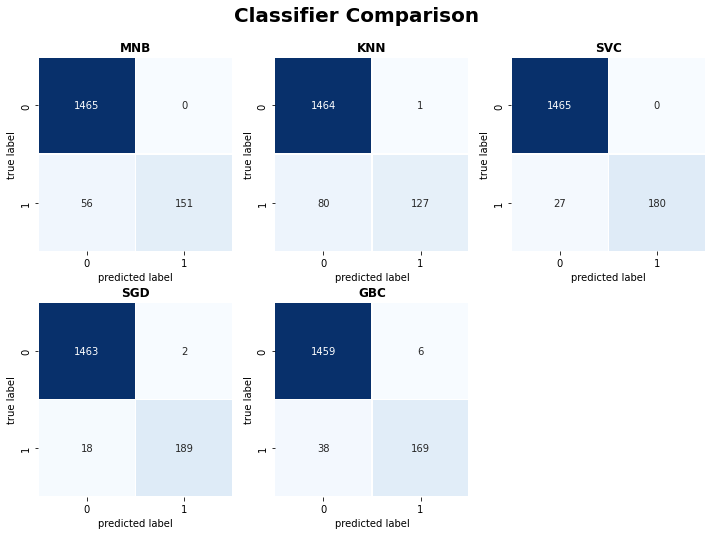

In [109]:
plot_all_confusion_matrices(label_test, dict_pred, "Classifier Comparison")

### accuracy_score

classification accuracy = correct predictions / total predictions = (TP + TN) / (TP + TN + FP + FN)



In [110]:
dict_acc = {}
for clf in list_clf :
    dict_acc[clf] = accuracy_score(Label_test, dict_pred[clf])

In [111]:
for clf in list_clf :
    print(clf, " " , dict_acc[clf])

MNB   0.9665071770334929
KNN   0.9515550239234449
SVC   0.9838516746411483
SGD   0.9880382775119617
GBC   0.9736842105263158


### precision_score

In [112]:
for clf in list_clf :
    print(clf, " ", precision_score(Label_test, dict_pred[clf]))

MNB   1.0
KNN   0.9921875
SVC   1.0
SGD   0.9895287958115183
GBC   0.9657142857142857


### recall_score

In [113]:
for clf in list_clf :
    print(clf, " ", recall_score(Label_test, dict_pred[clf]))

MNB   0.7294685990338164
KNN   0.6135265700483091
SVC   0.8695652173913043
SGD   0.9130434782608695
GBC   0.8164251207729468


### f1_score

In [114]:
for clf in list_clf :
    print(clf, " ", f1_score(Label_test, dict_pred[clf]))

MNB   0.8435754189944134
KNN   0.7582089552238805
SVC   0.9302325581395349
SGD   0.949748743718593
GBC   0.8848167539267014
